## Import libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
#from kneed import KneeLocator
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from os import listdir
from os.path import isfile, join
import os
import datetime as dt
import scipy.io
import glob
import pyresample
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import netCDF4
import datetime as dt
from netCDF4 import date2num,num2date
import matplotlib.colors as colors
import matplotlib as mpl
from netCDF4 import Dataset
import IPython.display
import cmocean
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.dates as mdates
import plotly.express as px
from matplotlib.ticker import NullFormatter
from matplotlib import rc
#import cosima_cookbook as cc
#from mpl_toolkits.basemap import Basemap
import math
import time
import sys

# plotting
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

def get_var_list(list_name):
    '''
    Get a list of variables associated with a pre-defined name.
    '''
    if list_name == 'ocn':
        var_list = ['sst','sss','uocn','vocn','frzmlt']
    elif list_name == 'atmo':
        var_list = ['Tair','uatm','vatm','fswdn','flwdn','snow']
    elif list_name == 'wave':
        var_list = ['aice','wave_sig_ht','peak_period','mean_wave_dir']
    elif list_name == 'ice':
        var_list = ['aice','hi','fsdrad','iage','uvel','vvel','frazil','congel']
    elif list_name == 'JRA55':
            var_list = ['airtmp']
    elif list_name == 'static':
#        var_list = ['aice','hi','hs','fsdrad','sice','iage','vlvl','vrdg']
        var_list = ['aice','hi','hs','fsdrad','iage']
    elif list_name == 'analysis':
        var_list = ['daidtt','daidtd','Tsfc','shear','divu','strength','frazil','congel','Tair','trsig','uvel','vvel','strairx','strairy','strocnx','strocny','strintx','strinty','strcorx','strcory','wave_sig_ht','peak_period','sst','frzmlt']
    else:
        var_list = [list_name]

    return var_list

def ProgressBar(Total, Progress, BarLength=20, ProgressIcon="#", BarIcon="-"):
    try:
        # You can't have a progress bar with zero or negative length.
        if BarLength <1:
            BarLength = 20
        # Use status variable for going to the next line after progress completion.
        Status = ""
        # Calcuting progress between 0 and 1 for percentage.
        Progress = float(Progress) / float(Total)
        # Doing this conditions at final progressing.
        if Progress >= 1.:
            Progress = 1
            Status = "\r\n"    # Going to the next line
        # Calculating how many places should be filled
        Block = int(round(BarLength * Progress))
        # Show this
        Bar = "[{}] {:.0f}% {}".format(ProgressIcon * Block + BarIcon * (BarLength - Block), round(Progress * 100, 0), Status)
        return Bar
    except:
        return "ERROR"


def ShowBar(Bar):
    sys.stdout.write(Bar)
    sys.stdout.flush()

def cice_netcdf_to_df(mypath, year):
    '''
    Convert a year of CICE history files into a pandas dataframe.
    '''
    os.chdir(mypath)
    file_dates = []
    print(year)
    filename =  mypath + 'iceh.' + str(year) + '-01-01.nc'

    onlyfiles = glob.glob("{path}/iceh.*{year}*".format(path=mypath, year=year))
    onlyfiles.sort()

    ds = xr.open_dataset(filename)
    LN = ds.TLON.values
    LT = ds.TLAT.values
    # Get the total number of grid points
    size = 1
    for dim in np.shape(LN): size *= dim
    aice_data = ds['aice'][0,:,:]
    mask1 = np.ma.masked_where(LT > 0.0, aice_data)
    mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
    master_mask = mask1.mask | mask2.mask
    mask = master_mask

    X_out =  np.ma.masked_array(np.empty((size,1)), mask=mask)
    
    # Loop over the files in that year
    for filecount, file in enumerate(onlyfiles):
        progressBar = "\rProgress: " + ProgressBar(len(onlyfiles), filecount+1, 20, '#', '.')
        ShowBar(progressBar)
        
        # Open the file
        filename = file
        file_dates.append(np.datetime64(file[-13:-3]))
        ds = xr.open_dataset(filename)
        
        # Get and apply masks to remove the ocean
        aice_data = ds['aice'][0,:,:]
        mask1 = np.ma.masked_where(LT > 0.0, aice_data)
        mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
        master_mask = mask1.mask | mask2.mask
        mask = master_mask
        
        # Get all the variables
        for counter, exp in enumerate(variable_list):
            data = ds[exp][0,:,:]
            data_masked = np.ma.masked_where(mask, data.values)
            data_masked_vec = data_masked.compressed()
            row_length, = data_masked_vec.shape

            if counter == 0: 
                # First file, then initialise X_temp
                X_single_file = data_masked_vec.reshape(row_length,1)
            else:
                # Else just concatenate the new data on
                X_single_file = np.concatenate([X_single_file, data_masked_vec.reshape(row_length,1)],axis=1)

        # Add on the corresponding coordinates
        LN_masked = np.ma.masked_where(mask, LN)
        LN_vec = LN_masked.compressed()
        LT_masked = np.ma.masked_where(mask, LT)
        LT_vec = LT_masked.compressed()
        X_single_file = np.concatenate([X_single_file, LN_vec.reshape(row_length,1), LT_vec.reshape(row_length,1)],axis=1)
        
        if filecount == 0: 
            # Day 1, then initialise the year file
            X_year = X_single_file
            datetime_vec =  np.tile(np.datetime64(file[-13:-3]),(row_length,1))
        else:
            X_year = np.concatenate([X_year, X_single_file],axis=0)
            datetime_vec = np.concatenate([datetime_vec, np.tile(np.datetime64(file[-13:-3]),(row_length,1))],axis=0)
    # Save as dataframe
    df_raw = pd.DataFrame(X_year, columns = variable_list+['longitude','latitude'])#,'date'])
    df_raw['date'] = datetime_vec
    print(datetime_vec.shape)
    df_raw = df_raw.dropna()
    
    return df_raw

def standardise(df_raw):
    X_temp = df_raw['aice'].values
    len_X, = X_temp.shape
    row_index = len_X
    X_train = np.zeros((row_index,1))
    for counter, exp in enumerate(variable_list):
#        progressBar = "\rProgress: " + ProgressBar(counter, len(variable_list), 20, '#', '.')
#        ShowBar(progressBar)
        
        X_temp_vec = df_raw[exp].values

        min_max_scaler = preprocessing.MinMaxScaler()
        X_temp_vec = min_max_scaler.fit_transform(X_temp_vec.reshape(row_index,1))

        # Log transformation
       # X_temp_vec = np.log(X_temp_vec+1)
       # scaler = StandardScaler()
#        X_temp_vec = min_max_scaler.fit_transform(X_temp_vec.reshape(row_index,1))
        X_train = np.concatenate([X_train, X_temp_vec],axis=1)

    temp_lon = df_raw['longitude'].to_numpy()
    temp_lat = df_raw['latitude'].to_numpy()
    X_train = np.concatenate([X_train, temp_lon.reshape(row_index,1), temp_lat.reshape(row_index,1)],axis=1)
    X_train_out = np.delete(X_train,0,1)

    df_standard = pd.DataFrame(X_train_out, columns = variable_list+['longitude','latitude'])
    df_standard['date'] = df_raw['date'].values
    #print(df_standard.describe())
    return df_standard

def kmeans_cluster(df_raw, df_standard):
    # init_centroids_good = np.array([[0.76306007, 0.04041951, 0.02538844, 0.02783396, 0.05290037, 0.74416677],
    #                                 [0.96479608, 0.11019326, 0.10738233, 0.26478933, 0.07206991, 0.80610988],
    #                                 [0.96413898, 0.18858583, 0.14985236, 0.82837526, 0.10536767, 0.74644532]])
    
    init_centroids_good = np.array([[0.76306007, 0.04041951, 0.02538844, 0.02783396, 0.05290037],
                                    [0.96479608, 0.11019326, 0.10738233, 0.26478933, 0.07206991],
                                    [0.96413898, 0.18858583, 0.14985236, 0.82837526, 0.10536767]])

    kmeans = KMeans(
        init=init_centroids_good,
        n_clusters=3,
        n_init=1,
        max_iter=1,
        random_state=2020
    )
    
    # Take a sub-sample (same number of points for each date)
    df_temp = df_standard.drop(df_raw[df_raw.aice < 0.01].index)
    df_subsample = df_temp.groupby('date', group_keys=False).apply(lambda x: x.sample(500))
    X_train = df_subsample.iloc[:, [1,2,3,4,5]] 

    kmeans.fit(X_train)
    kmeans.cluster_centers_ = init_centroids_good

    X_all = df_standard.iloc[:, [1,2,3,4,5]] 
    predicted = kmeans.predict(X_all) 

    df_kmeans = df_standard
    df_kmeans['k'] = predicted
    
    print(kmeans.cluster_centers_)
    
    return df_kmeans

def map_to_netcdf(df_kmeans,savefilename,mypath,year):
    os.chdir(mypath)
    filename =  mypath + 'iceh.' + str(year) + '-01-01.nc'
    onlyfiles = glob.glob("{path}/iceh.*{year}*".format(path=mypath, year=year))
    onlyfiles.sort()
    
    filename = '/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2000-01-01.nc'
    ds = xr.open_dataset(filename)
    LN = ds.TLON.values
    LT = ds.TLAT.values
    
    unique_dates = df_kmeans['date'].unique()
    tmp1, = unique_dates.shape

    tmp2, tmp3 = LN.shape
    k_means_array = np.empty((tmp1,tmp2,tmp3))
    k_means_array[:] = np.nan

    date_length, = unique_dates.shape
    # Map the k values onto the grid
    for time_lp, date_tmp in enumerate(unique_dates):
        progressBar = "\rProgress: " + ProgressBar(date_length, time_lp+1, 20, '#', '.')
        ShowBar(progressBar)
        date_idx = df_kmeans['date'] == date_tmp

        lon = df_kmeans['longitude'][date_idx];
        lat = df_kmeans['latitude'][date_idx];
        k = df_kmeans['k'][date_idx];

        row_length = date_idx.sum()
        lon = lon.values.reshape(row_length,1)
        lat = lat.values.reshape(row_length,1)
        k = k.values.reshape(row_length,1)
        for row_lp in range(0, row_length):
            a = abs(LT-lat[row_lp])+abs(LN-lon[row_lp])
            i,j = np.unravel_index(a.argmin(),a.shape)
            k_means_array[time_lp,i,j] = k[row_lp]
  
    # Training variables for k-means
    aice_array = np.empty((tmp1,tmp2,tmp3))
    hi_array = np.empty((tmp1,tmp2,tmp3))
    hs_array = np.empty((tmp1,tmp2,tmp3))
    fsdrad_array = np.empty((tmp1,tmp2,tmp3))
    iage_array = np.empty((tmp1,tmp2,tmp3))
    # alvl_array = np.empty((tmp1,tmp2,tmp3))

    # Extra variables of interest
    swh_array = np.empty((tmp1,tmp2,tmp3))
    ppd_array = np.empty((tmp1,tmp2,tmp3))


    date_length, = unique_dates.shape

    for filecount, file in enumerate(onlyfiles):
        filename = file
        progressBar = "\rProgress: " + ProgressBar(date_length, filecount+1, 20, '#', '.')
        ShowBar(progressBar)

        ds = xr.open_dataset(filename)
        LN = ds.TLON.values
        LT = ds.TLAT.values

        aice_data = ds['aice'][0,:,:]

        mask1 = np.ma.masked_where(LT > 0.0, aice_data)
        mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
        master_mask = mask1.mask | mask2.mask
        mask = master_mask

        data = ds['aice'][0,:,:]
        aice_array[filecount,:,:] = data
        aice_array[filecount,mask] = np.nan

        data = ds['hi'][0,:,:]
        hi_array[filecount,:,:] = data
        hi_array[filecount,mask] = np.nan

        data = ds['hs'][0,:,:]
        hs_array[filecount,:,:] = data
        hs_array[filecount,mask] = np.nan

        data = ds['fsdrad'][0,:,:]
        fsdrad_array[filecount,:,:] = data
        fsdrad_array[filecount,mask] = np.nan

        data = ds['iage'][0,:,:]
        iage_array[filecount,:,:] = data
        iage_array[filecount,mask] = np.nan

        # data = ds['alvl'][0,:,:]
        # alvl_array[filecount,:,:] = data
        # alvl_array[filecount,mask] = np.nan

        # Extra variables of interest
        data = ds['wave_sig_ht'][0,:,:]
        swh_array[filecount,:,:] = data
        swh_array[filecount,mask] = np.nan

        data = ds['peak_period'][0,:,:]
        ppd_array[filecount,:,:] = data
        ppd_array[filecount,mask] = np.nan
    
    # Save to netCDF
    ds = xr.open_dataset(filename)
    HTE = ds.HTE.values
    HTN = ds.HTN.values
    tarea = ds.tarea.values
    tmask = ds.tmask.values
    
    d_vars = {"k" : (['time','nj','ni'],k_means_array,
                                  {'long_name' :"k-means_clusters",
                                   'units'     :"cluster number",
                                   '_FillValue':-2e8}),
              "aice" : (['time','nj','ni'],aice_array,
                                  {'long_name' :"Areal sea ice area proportion of cell",
                                   'units'     :"-",
                                   '_FillValue':-2e8}),
              "hi" : (['time','nj','ni'],hi_array,
                                  {'long_name' :"Grid cell mean ice thickness",
                                   'units'     :"m",
                                   '_FillValue':-2e8}),
              "hs" : (['time','nj','ni'],hs_array,
                                  {'long_name' :"Grid cell mean snow thickness",
                                   'units'     :"m",
                                   '_FillValue':-2e8}),
              "fsdrad" : (['time','nj','ni'],fsdrad_array,
                                  {'long_name' :"Representative floe radius",
                                   'units'     :"m",
                                   '_FillValue':-2e8}),
              "iage" : (['time','nj','ni'],iage_array,
                                  {'long_name' :"Sea ice age",
                                   'units'     :"m",
                                   '_FillValue':-2e8}),
              # "alvl" : (['time','nj','ni'],alvl_array,
              #                     {'long_name' :"Level ice area fraction",
              #                      'units'     :"-",
              #                      '_FillValue':-2e8}),
              "wave_sig_ht" : (['time','nj','ni'],swh_array,
                                  {'long_name' :"Signficant wave height",
                                   'units'     :"m",
                                   '_FillValue':-2e8}),
              "HTE" : (['nj','ni'],HTE,
                              {'long_name':"T cell width on East side",
                               'units'    :"m",
                               '_FillValue':-2e8}),
              "HTN" : (['nj','ni'],HTN,
                              {'long_name':"T cell width on North side",
                               'units'    :"m",
                               '_FillValue':-2e8}),
              "tarea" : (['nj','ni'],tarea,
                              {'long_name':"area of T grid cells",
                               'units'    :"m^2",
                               '_FillValue':-2e8}),
              "tmask" : (['nj','ni'],tmask,
                              {'long_name':"ocean grid mask",
                               'units'    :"Boolean",
                               '_FillValue':-2e8})}

    coords = {"LON"  : (["nj","ni"],LN,{'units':'degrees_east'}),
              "LAT"  : (["nj","ni"],LT,{'units':'degrees_north'}),
              "time" : (["time"],unique_dates)}
    attrs = {'creation_date': "2023-05-12",#datetime.now().strftime('%Y-%m-%d %H'),
             'conventions'  : "",
             'title'        : "k-means clusters for CICE-WIM standalone 1-degree data",
             'source'       : ", ",
             'comment'      : "",
             'author'       : 'Noah Day',
             'email'        : 'noah.day@adelaide.edu.au'}
    enc_dict  = {'shuffle':True,'zlib':True,'complevel':5} 
    nc_out = xr.Dataset(data_vars=d_vars,coords=coords,attrs=attrs)
    write_job = nc_out.to_netcdf(savefilename,unlimited_dims=['time'],compute=False)

## Read in data

## Read in data

In [42]:
# Initialise parameters
case = 'waves-10-clim-1980'
mypath = '/g/data/ia40/cice-dirs/runs/'+case+'/history/'
savepath = '/g/data/ia40/sea-ice-classification/dataframes/'
year = 1983

In [43]:
# Read in the CICE data
var_name = 'static'
variable_list = get_var_list(var_name)
num_variables = np.size(variable_list)

df = cice_netcdf_to_df(mypath, year)
savefilename = 'raw_'+case+str(year)+'.csv'
df.to_csv(savepath+savefilename)


1983
Progress: [####################] 100% 
(6760513, 1)


In [44]:
# Standardise the variables

df_raw = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/raw_'+case+str(year)+'.csv')
df_standard = standardise(df_raw)
savefilename = 'standard_'+case+str(year)+'.csv'
df_standard.to_csv(savepath+savefilename)

print(df_standard.describe())

# Cluster
df_raw = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/raw_'+case+str(year)+'.csv')
df_standard = pd.read_csv('/g/data/ia40/sea-ice-classification/dataframes/standard_'+case+str(year)+'.csv')
df_kmeans = kmeans_cluster(df_raw, df_standard)
savefilename = 'kmeans_'+case+str(year)+'.csv'
df_kmeans.to_csv(savepath+savefilename)

print(df_kmeans.groupby('k').describe())

               aice            hi            hs        fsdrad          iage  \
count  2.088513e+06  2.088513e+06  2.088513e+06  2.088513e+06  2.088513e+06   
mean   9.417620e-01  1.755815e-01  1.439303e-01  5.411898e-01  1.005289e-01   
std    1.372705e-01  9.014235e-02  9.509916e-02  3.603398e-01  8.365927e-02   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    9.544129e-01  1.072603e-01  6.555925e-02  1.867638e-01  4.520955e-02   
50%    9.962404e-01  1.728228e-01  1.351775e-01  5.652010e-01  8.728848e-02   
75%    9.997280e-01  2.383334e-01  2.127608e-01  9.171953e-01  1.355673e-01   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

          longitude      latitude  
count  2.088513e+06  2.088513e+06  
mean   2.057922e+02 -6.838203e+01  
std    1.011855e+02  5.170298e+00  
min    5.000000e-01 -7.762990e+01  
25%    1.505000e+02 -7.243740e+01  
50%    2.085000e+02 -6.870660e+01  
75%    3.055000e+02 -6.444659e+01  


In [45]:
# Map to a netCDF
savefilename='/g/data/ia40/sea-ice-classification/kmean_'+case+str(year)+'.nc'
map_to_netcdf(df_kmeans,savefilename,mypath,year)

Progress: [####################] 100% 
Progress: [####################] 100% 


## MIZ widths

200


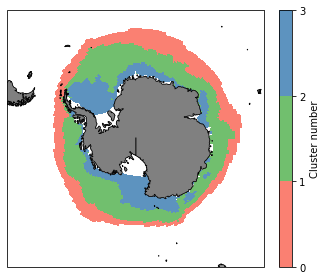

In [6]:
# Make a map to check what clusters are
case = 'waves-10-clim-2010'
year = 2013
filename = '/g/data/ia40/sea-ice-classification/kmean_'+case+str(year)+'.nc'
ds = xr.open_dataset(filename)
LT = ds['LAT']
LN = ds['LON']

day = 200
print(day)

n_days, n_lat, n_lon = ds['k'].shape

# Plot this on a map        
fontprops = fm.FontProperties(size=18)
plt.figure()
clevs=np.arange(0,4,1)

coord_lims = [-180, 180, -50, -90]
# Make a colormap
cmap = mpl.colors.ListedColormap([(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)])
# define the bins and normalize
bounds = np.linspace(0, 3, 4)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent(coord_lims, ccrs.PlateCarree())
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                        edgecolor='black', facecolor='gray', linewidth=0.5)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
p = ax.pcolormesh(LN, LT, ds['k'][day,:,:],
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
#                norm=colors.LogNorm(vmin=1, vmax=1000),
            shading='auto')
#plt.title(str(n_clusters)+" clusters")

cb = plt.colorbar(p, orientation='vertical', fraction=0.046, pad=0.04, label='Cluster number') 
savepath = '/home/566/nd0349/notebooks/'
plt.tight_layout()
plt.savefig(savepath+'kmeans_map_day_200_'+case+str(year)+'.png', dpi = 300) 


In [7]:
# Calculate MIZ width


miz_cluster = 0 # What cluster does the MIZ correspond with?

# Initialise arrays
n_days, n_lat, n_lon = ds['k'].shape

miz_width_array = np.empty((n_days,n_lon))
effective_miz_width_array = np.empty((n_days,n_lon))
sic_width_array = np.empty((n_days,n_lon))

miz_upper_boundary = np.empty((n_days,n_lon))
miz_lower_boundary = np.empty((n_days,n_lon))


day_vec = range(0,n_days,1)

# Circumpolar for each day
for day_idx in day_vec:
    progressBar = "\rProgress: " + ProgressBar(n_days, day_idx+1, 20, '#', '.')
    ShowBar(progressBar)
    for lon_idx in range(0,n_lon):
        # MIZ width
        miz_idx = ds['k'][day_idx,:,lon_idx].data == miz_cluster
#        locs = [i for i, x in enumerate(np.diff(miz_idx)) if x]
#        if len(locs) >= 2:
#            miz_idx[0:locs[-2]] = False
        sic_idx = ds['aice'][day_idx,:,lon_idx].data > 0.15
        miz_idx = miz_idx*sic_idx
        sic_1580_idx = np.logical_and(sic_idx,ds['aice'][day_idx,:,lon_idx].data < 0.8)
        if not any(miz_idx):
            if not any(sic_idx):
                # If there is no ice we can't count the MIZ
                miz_width_array[day_idx,lon_idx] = np.nan
                effective_miz_width_array[day_idx,lon_idx] = np.nan
            else:
                # If there are no MIZ cells then set distance to 0
                miz_width_array[day_idx,lon_idx] = 0
                effective_miz_width_array[day_idx,lon_idx] = 0
            
            
            miz_upper_boundary[day_idx,lon_idx] = LT[0,lon_idx]
            miz_lower_boundary[day_idx,lon_idx] = LT[0,lon_idx]
        else:
            miz_width_array[day_idx,lon_idx] = ds['HTE'][miz_idx,lon_idx].data.sum()
            effective_miz_width_array[day_idx,lon_idx] = np.multiply(ds['HTE'][miz_idx,lon_idx].data, ds['aice'][day_idx,miz_idx,lon_idx].data).sum()
            
            locs = np.asarray(miz_idx).nonzero()
            miz_upper_boundary[day_idx,lon_idx] = LT[locs[0][-1],lon_idx]
            miz_lower_boundary[day_idx,lon_idx] = LT[locs[0][0],lon_idx]
            
        if not any(sic_1580_idx):
            sic_width_array[day_idx,lon_idx] = 0
        else:
            sic_width_array[day_idx,lon_idx] = ds['HTE'][sic_1580_idx,lon_idx].data.sum()
print('Done!')

Progress: [####################] 100% 
Done!


In [8]:
filename="/g/data/ia40/sea-ice-classification/mizWidth_"+case+str(year)+".nc"
d_vars = {"effective" : (['time','nj'],effective_miz_width_array,
                              {'long_name' :"Effective width",
                               'units'     :"m",
                               '_FillValue':-2e8}),
          "sic" : (['time','nj'],sic_width_array,
                              {'long_name' :"Sea ice concentration width [0.15, 0.8]",
                               'units'     :"m",
                               '_FillValue':-2e8}),
          "absolute" : (['time','nj'],miz_width_array,
                          {'long_name':"Absolute width",
                           'units'    :"m",
                           '_FillValue':-2e8}),
          "upper_location" : (['time','nj'],miz_upper_boundary,
                          {'long_name':"Northern MIZ boundary",
                           'units'    :"m",
                           '_FillValue':-2e8}),
         "lower_location" : (['time','nj'],miz_lower_boundary,
                              {'long_name' :"Southern MIZ boundary",
                               'units'     :"degrees",
                               '_FillValue':-2e8})}
          
coords = {"LON"  : (["nj"],LN[1,:].data,{'units':'degrees_east'}),
          "time" : (["time"],range(365))}
attrs = {'creation_date': "2023-05-29",#datetime.now().strftime('%Y-%m-%d %H'),
         'conventions'  : "",
         'title'        : "MIZ width for CICE-WIM standalone 1-degree data",
         'source'       : ", ",
         'comment'      : "",
         'author'       : 'Noah Day',
         'email'        : 'noah.day@adelaide.edu.au'}
enc_dict  = {'shuffle':True,'zlib':True,'complevel':5} 
nc_out = xr.Dataset(data_vars=d_vars,coords=coords,attrs=attrs)
write_job = nc_out.to_netcdf(filename,unlimited_dims=['time'],compute=False)#,encoding={'glbrad':enc_dict})

[46, 135, 258, 349]


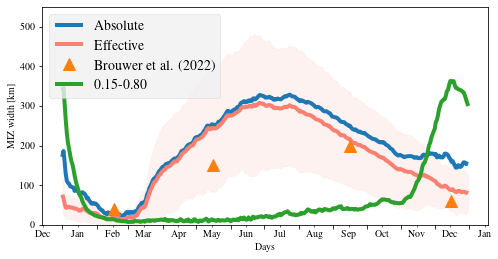

In [9]:
case = 'waves-10-clim-2010'
year = 2013
filename = "/g/data/ia40/sea-ice-classification/mizWidth_"+case+str(year)+".nc"
ds = xr.open_dataset(filename)
effective_miz_width_array = ds['effective']
miz_width_array = ds['absolute']
sic_width_array = ds['sic']


Cmap = np.asarray([[0.9805, 0.5000, 0.4453], [0.4416, 0.7490, 0.4322], [0.3639, 0.5755, 0.748]])
    
    
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
#x_dates = np.array(unique_dates[day_vec], dtype=np.datetime64)
x_dates = range(0,365)
day_vec = x_dates
month_year_formatter = mdates.DateFormatter('%b') # The "," is intentional.

# Plot the MIZ widths
fig, ax = plt.subplots(figsize=(8, 4))

monthly_locator = mdates.MonthLocator()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

brouwer_dates = [31+15,31+28+31+30+15,31+28+31+30+31+30+31+31+15,31+28+31+30+31+30+31+31+30+31+30+15]
brouwer_linear_centre = [36.187, 143.457, 192.569, 60.743]
brouwer_linear_lower = [20.679, 100.808, 125.363, 33.603]
brouwer_linear_upper = [60.743, 186.107, 275.283, 148.627]

print(brouwer_dates)

print(mdates.MonthLocator(bymonthday=15))

#plt.style.use("ggplot")
plt.style.use("fivethirtyeight")

line_deviation = 1 * (effective_miz_width_array[day_vec,:].std(axis=1)/1000)
mean = effective_miz_width_array[day_vec,:].mean(axis=1)/1000
lower = (mean - line_deviation)
upper = (mean + line_deviation)

plt.plot(x_dates, miz_width_array[day_vec,:].mean(axis=1)/1000, label = "Absolute")
plt.plot(x_dates, mean, label = "Effective", color=Cmap[0,:])
plt.plot(brouwer_dates,[40,150,200,60], '^', markersize=12, label = "Brouwer et al. (2022)")
plt.plot(x_dates, sic_width_array[day_vec,:].mean(axis=1)/1000, label = "0.15-0.80")


plt.fill_between(x_dates, lower, upper, color=Cmap[0,:], alpha=.1)


#plt.xticks(range(0, n_days))

plt.xlabel("Days")
plt.ylabel("MIZ width [km]")
plt.legend()
ax.set_ylim([0, 550])
plt.show()

fig.autofmt_xdate()
savepath = '/home/566/nd0349/notebooks/'
fig.savefig(savepath+'miz_width_'+case+str(year)+'.png', dpi = 300) 


## MIZ Fraction

In [16]:
def get_lat_idx(lat, region):
    '''
    Get a list of variables associated with a pre-defined name.
    '''
    if region == 'Antarctic':
        idx = lat < -50
    elif region == 'Arctic':
        idx = lat > 45
    elif region == 'SH':
        idx = lat < 0
    elif region == 'NH':
        idx = lat > 0
    return idx

In [50]:
# Calculate MIZ fraction
case = 'waves-10-clim-1980'
year = 1983
filename = '/g/data/ia40/sea-ice-classification/kmean_'+case+str(year)+'.nc'
ds = xr.open_dataset(filename)
LT = ds['LAT']
LN = ds['LON']

miz_cluster = 0 # What cluster does the MIZ correspond with?

# Initialise arrays
n_days, n_lat, n_lon = ds['k'].shape

MIZ_area = np.empty((n_days))
SIC_area = np.empty((n_days))



day_vec = range(0,n_days)

region = 'Antarctic'


for day_idx in day_vec:
    progressBar = "\rProgress: " + ProgressBar(n_days, day_idx+1, 20, '#', '.')
    ShowBar(progressBar)

    ln = ds.LON.values
    lt = ds.LAT.values
    tarea = ds.tarea.values

    aice_temp = np.squeeze(ds.aice[day_idx,:,:])
    #idx = lt < 0
    idx = get_lat_idx(lt, region)
    aice = np.multiply(aice_temp,idx)
    data_timestep = np.sum(np.multiply(aice,tarea))
    SIC_area[day_idx] = data_timestep.values*(10 ** -6)
    
    tarea_MIZ = np.multiply(tarea,ds.k[day_idx,:,:]==miz_cluster)
    data_timestep_MIZ = np.sum(np.multiply(aice,tarea_MIZ))
    MIZ_area[day_idx] = data_timestep_MIZ.values*(10 ** -6)
    
#    data_vector += [data_timestep.values*(10 ** -6)]
    
df_area = pd.DataFrame(np.squeeze(np.transpose([[SIC_area], [MIZ_area]])), columns = ['SIA','MIZ_area'])
savefilename = 'SIA_MIZ_'+case+str(year)+'.csv'
savepath = '/g/data/ia40/sea-ice-classification/dataframes/'
df_area.to_csv(savepath+savefilename)


Progress: [####################] 100% 


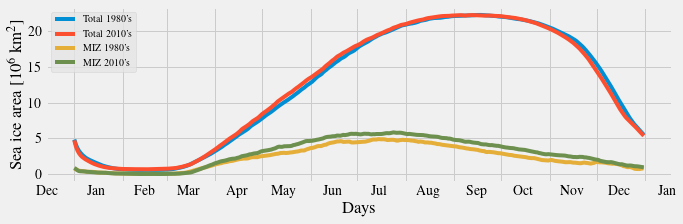

In [10]:
# Time series of MIZ AREA
savepath = '/g/data/ia40/sea-ice-classification/dataframes/'
df_1980 = pd.read_csv(savepath+'SIA_MIZ_waves-10-clim-19801983.csv')
df_2010 = pd.read_csv(savepath+'SIA_MIZ_waves-10-clim-20102013.csv')

Cmap = np.asarray([[0.9805, 0.5000, 0.4453], [0.4416, 0.7490, 0.4322], [0.3639, 0.5755, 0.748]])
    
    
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
#x_dates = np.array(unique_dates[day_vec], dtype=np.datetime64)
x_dates = range(365)
#list(range(120)) + list(range(160,365)) #[range(0,90), range(91,365)]
day_vec = x_dates
month_year_formatter = mdates.DateFormatter('%b') # The "," is intentional.

# Plot the MIZ widths
fig, ax = plt.subplots(figsize=(10, 3))

monthly_locator = mdates.MonthLocator()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))



#plt.style.use("fivethirtyeight")

plt.plot(x_dates, df_1980['SIA'][x_dates]/10**6, label = "Total 1980's")#, color="lightblue")
plt.plot(x_dates, df_2010['SIA'][x_dates]/10**6, label = "Total 2010's")#, color="blue")

plt.plot(x_dates, df_1980['MIZ_area'][x_dates]/10**6, label = "MIZ 1980's")#, color="orange")
plt.plot(x_dates, df_2010['MIZ_area'][x_dates]/10**6, label = "MIZ 2010's")#, color="crimson")

plt.style.use("ggplot")

#plt.xticks(range(0, n_days))

plt.xlabel("Days")
plt.ylabel("Sea ice area [10$^6$ km$^2$]")
plt.legend()
#ax.set_ylim([0, 550])
plt.show()

fig.autofmt_xdate()
savepath = '/home/566/nd0349/notebooks/'
fig.savefig(savepath+'sic_area'+case+str(year)+'.png', dpi = 600)


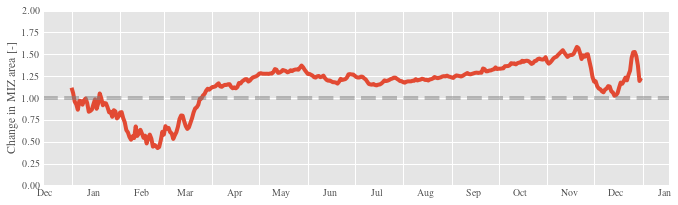

In [11]:
fig, ax = plt.subplots(figsize=(10, 3))

monthly_locator = mdates.MonthLocator()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

plt.plot(df_2010['MIZ_area'][x_dates]/df_1980['MIZ_area'][x_dates])
plt.axhline(y = 1.0, color = 'gray', linestyle = '--',alpha=0.5)
plt.ylabel("Change in MIZ area [-]")
plt.ylim((0,2))
fig.savefig(savepath+'miz_ratio'+case+str(year)+'.png', dpi = 600)

In [12]:
(df_2010['MIZ_area']/df_1980['MIZ_area']).mean()

1.1505546077969209

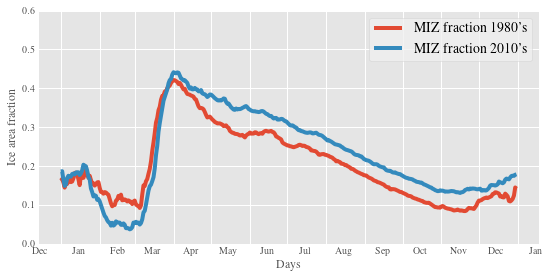

In [13]:
# MIZ fraction

savepath = '/g/data/ia40/sea-ice-classification/dataframes/'
df_1980 = pd.read_csv(savepath+'SIA_MIZ_waves-10-clim-19801983.csv')
df_2010 = pd.read_csv(savepath+'SIA_MIZ_waves-10-clim-20102013.csv')

Cmap = np.asarray([[0.9805, 0.5000, 0.4453], [0.4416, 0.7490, 0.4322], [0.3639, 0.5755, 0.748]])
    
    
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
#x_dates = np.array(unique_dates[day_vec], dtype=np.datetime64)
x_dates = range(0,365)
day_vec = x_dates
month_year_formatter = mdates.DateFormatter('%b') # The "," is intentional.

# Plot the MIZ widths
fig, ax = plt.subplots(figsize=(8, 4))

monthly_locator = mdates.MonthLocator()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))


#plt.style.use("ggplot")
plt.style.use("fivethirtyeight")

plt.plot(x_dates, df_1980['MIZ_area']/df_1980['SIA'], label = "MIZ fraction 1980's")
plt.plot(x_dates, df_2010['MIZ_area']/df_2010['SIA'], label = "MIZ fraction 2010's")


#plt.xticks(range(0, n_days))

plt.xlabel("Days")
plt.ylabel("Ice area fraction")
plt.legend()
ax.set_ylim([0, 0.6])
plt.show()

fig.autofmt_xdate()
savepath = '/home/566/nd0349/notebooks/'
fig.savefig(savepath+'miz_fraction'+case+str(year)+'.png', dpi = 300) 


,Unnamed: 0,SIA,MIZ_area
0,0,4.733319e+06,8.802232e+05
1,1,3.895688e+06,7.274582e+05
2,2,3.325313e+06,5.496947e+05
3,3,2.925389e+06,4.358445e+05
4,4,2.634026e+06,4.009961e+05
...,...,...,...
360,360,6.306779e+06,1.099965e+06
361,361,6.071707e+06,1.063615e+06
362,362,5.830430e+06,1.018696e+06
363,363,5.595406e+06,9.937541e+05


In [38]:
# Analysis dataset

variable_list = ['uvel','vvel','wave_sig_ht','peak_period','Tair','sst','sss','strairx','strairy','strocnx','strocny','strcorx','strcory','strtltx','strtlty','strintx','strinty','strength','divu','shear','uatm','vatm','uocn','vocn','frzmlt','daidtd','daidtt','meltt','meltb','meltl','Tsfc','sice']
num_variables = np.size(variable_list)

savepath = '/home/566/nd0349/notebooks/'
mypath = '/g/data/ia40/cice-dirs/runs/'+case+'/history/'
year = 2013

NFSD = np.asarray([2.6884, 9.7984, 21.6721, 40.7349, 70.1407, 113.6938, 175.5771, 259.8365, 369.6202, 506.2401, 668.2091, 850.4769])
floe_binwidth = np.asarray([5.2438, 8.9763, 14.7711, 23.3545, 35.4569, 51.6493, 72.1173, 96.4015, 123.1658, 150.0741, 173.8638, 190.6719])


os.chdir(mypath)
file_dates = []
print(year)
filename =  mypath + 'iceh.' + str(year) + '-01-01.nc'

onlyfiles = glob.glob("{path}/iceh.*{year}*".format(path=mypath, year=year))
onlyfiles.sort()
print(filename)
ds = xr.open_dataset(filename)
LN = ds.TLON.values
LT = ds.TLAT.values
# Get the total number of grid points
size = 1
for dim in np.shape(LN): size *= dim
aice_data = ds['aice'][0,:,:]
mask1 = np.ma.masked_where(LT > 0.0, aice_data)
mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
master_mask = mask1.mask | mask2.mask
mask = master_mask

X_out =  np.ma.masked_array(np.empty((size,1)), mask=mask)

# Loop over the files in that year
for filecount, file in enumerate(onlyfiles):
    progressBar = "\rProgress: " + ProgressBar(len(onlyfiles), filecount+1, 20, '#', '.')
    ShowBar(progressBar)

    # Open the file
    filename = file
    file_dates.append(np.datetime64(file[-13:-3]))
    ds = xr.open_dataset(filename)

    # Get and apply masks to remove the ocean
    aice_data = ds['aice'][0,:,:]
    mask1 = np.ma.masked_where(LT > 0.0, aice_data)
    mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
    master_mask = mask1.mask | mask2.mask
    mask = master_mask

    # Get all the variables
    for counter, exp in enumerate(variable_list):
        data = ds[exp][0,:,:]
        data_masked = np.ma.masked_where(mask, data)
        data_masked_vec = data_masked.compressed()
        row_length, = data_masked_vec.shape

        if counter == 0: 
            # First file, then initialise X_temp
            X_single_file = data_masked_vec.reshape(row_length,1)
        else:
            # Else just concatenate the new data on
            X_single_file = np.concatenate([X_single_file, data_masked_vec.reshape(row_length,1)],axis=1)

    
    
    # Add on the corresponding coordinates
    LN_masked = np.ma.masked_where(mask, LN)
    LN_vec = LN_masked.compressed()
    LT_masked = np.ma.masked_where(mask, LT)
    LT_vec = LT_masked.compressed()
    X_single_file = np.concatenate([X_single_file, LN_vec.reshape(row_length,1), LT_vec.reshape(row_length,1)],axis=1)

    if filecount == 0: 
        # Day 1, then initialise the year file
        X_year = X_single_file
        datetime_vec =  np.tile(np.datetime64(file[-13:-3]),(row_length,1))
    else:
        X_year = np.concatenate([X_year, X_single_file],axis=0)
        datetime_vec = np.concatenate([datetime_vec, np.tile(np.datetime64(file[-13:-3]),(row_length,1))],axis=0)
# Save as dataframe
df_raw = pd.DataFrame(X_year, columns = variable_list+['longitude','latitude'])#,'date'])
df_raw['date'] = datetime_vec
print(datetime_vec.shape)
df_raw = df_raw.dropna()

savepath = '/g/data/ia40/sea-ice-classification/dataframes/'
savefilename = 'forcing_analysis_'+case+str(year)+'.csv'
df_raw.to_csv(savepath+savefilename)

2013
/g/data/ia40/cice-dirs/runs/waves-10-clim-2010/history/iceh.2013-01-01.nc
Progress: [####################] 100% 
(6766151, 1)
